## 2.1 Import Python Libraries

In [4]:
import boto3, cv2, time, numpy as np, matplotlib.pyplot as plt, random
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.deserializers import JSONDeserializer

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## 2.2 Check if Endpoint creation is successful and create the predictor

In [5]:
sm_client = boto3.client(service_name="sagemaker")

# Restore the endpoint name stored in the 2_DeployEndpoint.ipynb notebook
%store -r ENDPOINT_NAME
print(f'Endpoint Name: {ENDPOINT_NAME}')

endpoint_created = False
while True:
    response = sm_client.list_endpoints()
    for ep in response['Endpoints']:
        print(f"Endpoint Status = {ep['EndpointStatus']}")
        if ep['EndpointName']==ENDPOINT_NAME and ep['EndpointStatus']=='InService':
            endpoint_created = True
            break
    if endpoint_created:
        break
    time.sleep(5)

Endpoint Name: yolov8-pytorch-2024-01-19-03-57-03-986580
Endpoint Status = InService


In [6]:
predictor = PyTorchPredictor(endpoint_name=ENDPOINT_NAME,
                             deserializer=JSONDeserializer())

## 2.3 Run Inference and Generate output results

Inference Time = 0.9036 seconds


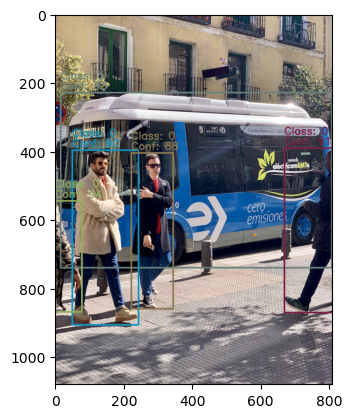

In [19]:
infer_start_time = time.time()

orig_image = cv2.imread('bus.jpg')

image_height, image_width, _ = orig_image.shape
model_height, model_width = 300, 300
x_ratio = image_width/model_width
y_ratio = image_height/model_height

resized_image = cv2.resize(orig_image, (model_height, model_width))
payload = cv2.imencode('.jpg', resized_image)[1].tobytes()
result = predictor.predict(payload)

infer_end_time = time.time()

print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")

if 'boxes' in result:
    for idx,(x1,y1,x2,y2,conf,lbl) in enumerate(result['boxes']):
        # Draw Bounding Boxes
        x1, x2 = int(x_ratio*x1), int(x_ratio*x2)
        y1, y2 = int(y_ratio*y1), int(y_ratio*y2)
        color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
        cv2.rectangle(orig_image, (x1,y1), (x2,y2), color, 4)
        cv2.putText(orig_image, f"Class: {int(lbl)}", (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
        cv2.putText(orig_image, f"Conf: {int(conf*100)}", (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
        if 'masks' in result:
            # Draw Masks
            mask = cv2.resize(np.asarray(result['masks'][idx]), dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            for c in range(3):
                orig_image[:,:,c] = np.where(mask>0.5, orig_image[:,:,c]*(0.5)+0.5*color[c], orig_image[:,:,c])

if 'probs' in result:
    # Find Class
    lbl = result['probs'].index(max(result['probs']))
    color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
    cv2.putText(orig_image, f"Class: {int(lbl)}", (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    
if 'keypoints' in result:
    # Define the colors for the keypoints and lines
    keypoint_color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
    line_color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))

    # Define the keypoints and the lines to draw
    # keypoints = keypoints_array[:, :, :2]  # Ignore the visibility values
    lines = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head
        (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),  # Torso
        (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)  # Legs
    ]

    # Draw the keypoints and the lines on the image
    for keypoints_instance in result['keypoints']:
        # Draw the keypoints
        for keypoint in keypoints_instance:
            if keypoint[2] == 0:  # If the keypoint is not visible, skip it
                continue
            cv2.circle(orig_image, (int(x_ratio*keypoint[:2][0]),int(y_ratio*keypoint[:2][1])), radius=5, color=keypoint_color, thickness=-1)

        # Draw the lines
        for line in lines:
            start_keypoint = keypoints_instance[line[0]]
            end_keypoint = keypoints_instance[line[1]]
            if start_keypoint[2] == 0 or end_keypoint[2] == 0:  # If any of the keypoints is not visible, skip the line
                continue
            cv2.line(orig_image, (int(x_ratio*start_keypoint[:2][0]),int(y_ratio*start_keypoint[:2][1])),(int(x_ratio*end_keypoint[:2][0]),int(y_ratio*end_keypoint[:2][1])), color=line_color, thickness=2)

plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
plt.show()

## 2.4 Cleanup by removing Endpoint, Endpoint Config and Model

In [ ]:
# response = sm_client.describe_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
# print(response)
# endpoint_config_name = response['EndpointConfigName']

# # Delete Endpoint
# sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)

# # Delete Endpoint Configuration
# sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

# # Delete Model
# for prod_var in response['ProductionVariants']:
#     model_name = prod_var['ModelName']
#     sm_client.delete_model(ModelName=model_name)     

In [20]:
!pip install locust

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 85.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.7/103.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 38.1 MB/s eta 0:00:00
  Created wheel for Flask-BasicAuth: filename=Flask_BasicAuth-0.2.0-py3-none-any.whl size=4241 sha256=78bbc87a020a9c8043b0b5ebffcc9b3cafa952137ee58984149542baf53bd5f3
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/2c/96/a5/54f6f7fa880f487e2f6c52cc9943d3299272a956cbd5af3b8c
  Created wheel for roundrobin: filename=roundrobin-0.0.4-py3-none-any.whl size=4017 sha256=fabf64ce9c7d066972d0fe692967c9e267b59fff6f97fbc101eab173236a076d
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/c2/

In [2]:
%%time

import asyncio
from concurrent.futures import ThreadPoolExecutor
import boto3, cv2, time, numpy as np, matplotlib.pyplot as plt, random
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.deserializers import JSONDeserializer
import nest_asyncio
nest_asyncio.apply()

_executor = ThreadPoolExecutor(100)
loop = asyncio.get_event_loop()

orig_image = cv2.imread('bus.jpg')

image_height, image_width, _ = orig_image.shape
model_height, model_width = 300, 300
x_ratio = image_width/model_width
y_ratio = image_height/model_height

resized_image = cv2.resize(orig_image, (model_height, model_width))
payload = cv2.imencode('.jpg', resized_image)[1].tobytes()

%store -r ENDPOINT_NAME
print(f'Endpoint Name: {ENDPOINT_NAME}')

def long_running_task():
    local_predictor = PyTorchPredictor(endpoint_name=ENDPOINT_NAME,
                             deserializer=JSONDeserializer())
    # Perform a long-running task here
    local_predictor.predict(payload)
    print("Task complete")

async def async_long_running_task():
    # run blocking function in another thread,
    # and wait for it's result:
    await loop.run_in_executor(_executor, long_running_task)

for i in range(0,1000):
    loop.create_task(async_long_running_task())

pending = asyncio.all_tasks()
loop.run_until_complete(asyncio.gather(*pending))

Endpoint Name: yolov8-pytorch-2024-01-19-03-57-03-986580
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/yolov8-pytorch-2024-01-19-03-57-03-986580 in account 348052051973 for more information.

In [26]:
loop.create_task(long_running_task())

<Task pending name='Task-115' coro=<long_running_task() running at /tmp/ipykernel_25461/1685317343.py:3>>

In [2]:
!pip install --upgrade boto3 botocore sagemaker

In [11]:
!pip install nest-asyncio


Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete


In [12]:
import nest_asyncio
nest_asyncio.apply()

Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
Task complete
